In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial


from urllib.parse import urlparse, parse_qsl
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *


from run_id import run_id

run_id = 1275

runstat = RunStats.objects.get(pk=run_id)

q = runstat.query


In [2]:
ar5 = AR.objects.get(ar=5)

docs = Doc.objects.filter(query=runstat.query,PY__lte=ar5.end)

docs.count()

266971

In [3]:
citations = IPCCRef.objects.all()

citations.count()

matched = citations.filter(doc__isnull=False)

unmatched = citations.filter(doc__isnull=True)

print("Matched {} documents\n".format(matched.count()))

print("Didn't match {} documents\n".format(unmatched.count()))

print("Matched {}% of documents\n".format(matched.count()/(matched.count()+unmatched.count())))

Matched 30332 documents

Didn't match 43179 documents

Matched 0.4126185196773272% of documents



In [4]:
df = pd.DataFrame.from_dict(list(unmatched.values('text','year')))
df.head()

,text,year
0,Assessing the Impact of the Clean Development ...,2012
1,Europe in the new millennium. In: Assessment...,2000
2,Transient response of a coupled ocean-atmosphe...,1991
3,'Quantitative introduction of tumors in mice w...,1941
4,Climatic Effects of Aerosols and Clouds. Sprin...,1999


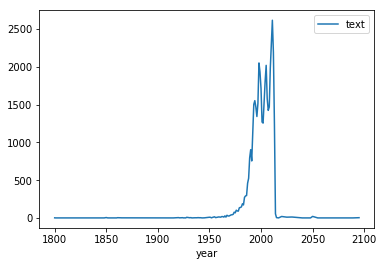

In [5]:
df.groupby(['year']).count().plot()

plt.show()

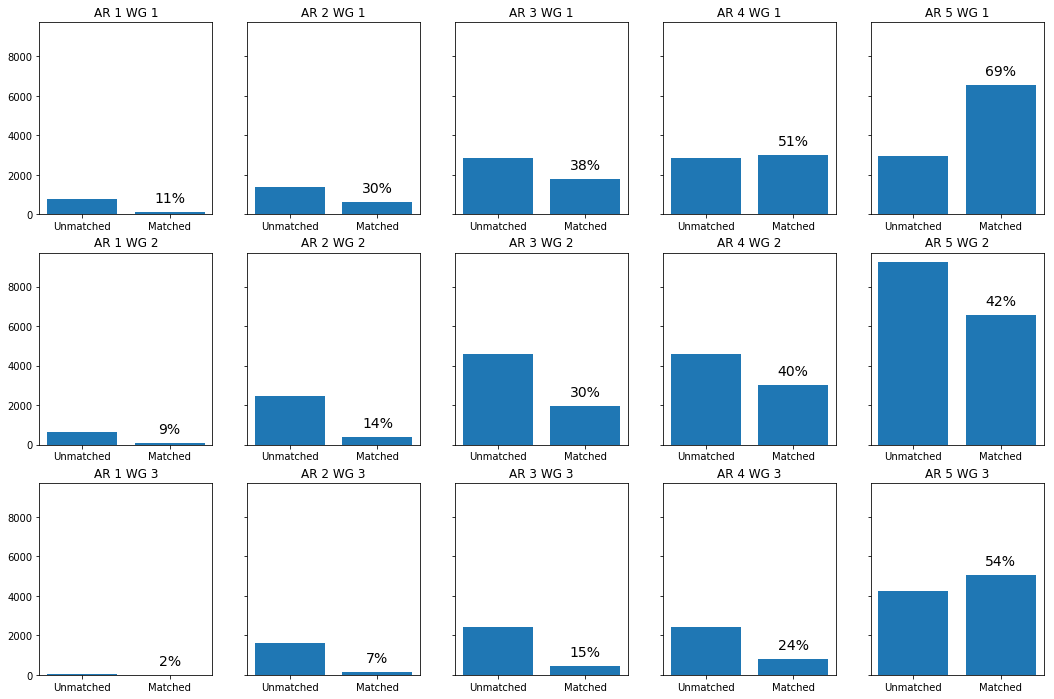

In [6]:
plt.rcParams["figure.figsize"] = [18,12]

fig, axs = plt.subplots(
    nrows=3,
    ncols=5,
    sharey=True#,
    #gridspec_kw=dict(hspace=0.4,)
)


for wg in WG.objects.all().order_by('ar','wg'):
    ax = axs[wg.wg-1][wg.ar.ar-1]
    irs = IPCCRef.objects.filter(
        ar=wg.ar,
        wg=wg
    )
    matched = irs.filter(doc__isnull=False).count()
    unmatched = irs.filter(doc__isnull=True).count()
    pcntage = round(matched / (matched+unmatched) * 100)
    ax.text(1,matched+500,"{}%".format(pcntage),ha="center",fontsize=14)
    ax.bar([0,1],[unmatched,matched])
    ax.set_xticks([0,1])
    ax.set_xticklabels(["Unmatched","Matched"])
    ax.set_title('AR {:.0f} WG {:.0f}'.format(wg.ar.ar,wg.wg))
    
plt.savefig('../plots/ipcc_matches.png',bbox_inches='tight')   
plt.show()

In [7]:
p = Project.objects.get(pk=110)
search_ids = []
qs = Query.objects.filter(project=p)
for q in qs.iterator():
    search_ids += q.title.split(' OR ')
search_ids = set(search_ids)

In [8]:

q = runstat.query
irs = IPCCRef.objects.filter(ar=5)
in_db = irs.filter(doc__isnull=False)
in_hc = irs.filter(doc__query=q)
found = set(irs.filter(doc__query__project=p))
unfound = search_ids - found
no_db = set(irs.filter(doc__isnull=True).values_list('pk',flat=True))
unlooked = no_db - search_ids

print(f"IPCC refs: {irs.count()}")
print(f"In db: {in_db.count()}")
print(f"In Grineisen: {in_hc.count()}")
print(f"Found: {len(found)}")
print(f"not found: {len(unfound)}")
print(f"still to search: {len(unlooked)}")

IPCC refs: 34624
In db: 18150
In Grineisen: 14106
Found: 2855
not found: 9468
still to search: 16474


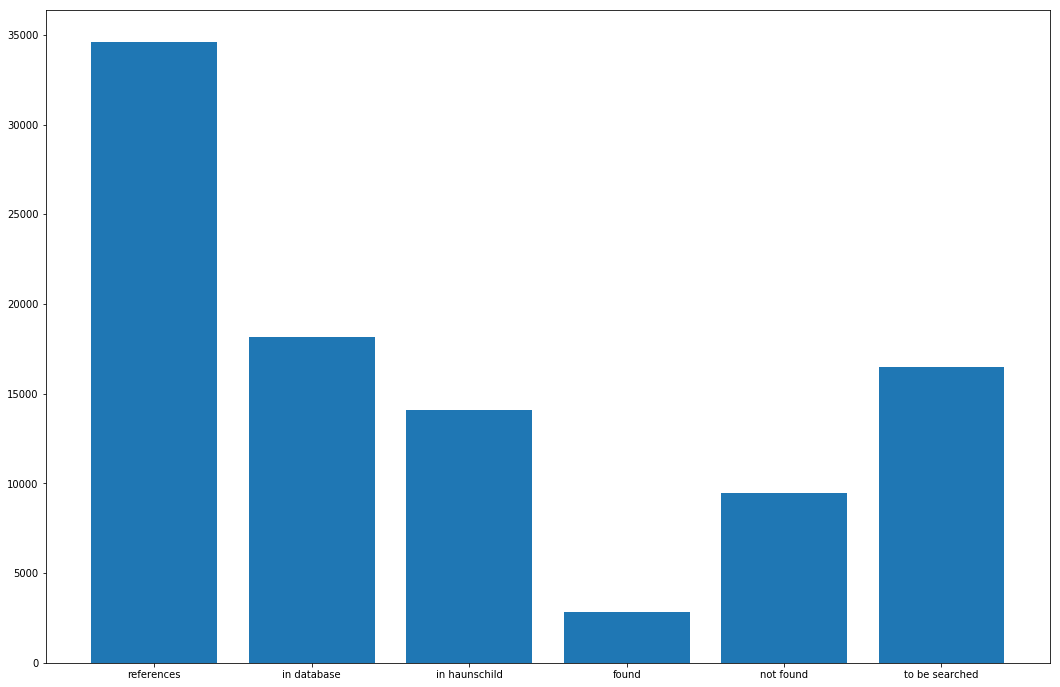

In [9]:
fig, ax = plt.subplots()
x = [0,1,2,3,4,5]
ax.bar(
    x,
    [irs.count(),in_db.count(),in_hc.count(),len(found),len(unfound),len(unlooked)]
)
ax.set_xticks(x)
ax.set_xticklabels([
    "references",
    "in database",
    "in haunschild",
    "found",
    "not found",
    "to be searched"
])

plt.savefig("../plots/ipcc_matching.png")

In [10]:
def random_list(l,n):
    return [ l[i].id for i in sorted(random.sample(range(len(l)), n)) ]

ir_sample = IPCCRef.objects.filter(id__in=random_list(unmatched,10))

df = pd.DataFrame.from_dict(list(ir_sample.values('text','ar','wg__wg','authors','year')))

df.head(10)


TypeError: object of type 'int' has no len()

In [ ]:
cformat = 'l l p{4.5cm} p{2.5cm} r'

df = df.rename(columns={"wg__wg":"WG","ar":"AR"})
df = df[['AR','WG','text','authors','year']]
df.head()
with pd.option_context('display.max_colwidth', -1):
    df.to_latex('../tables/ipcc_matching_sample.tex',column_format=cformat,index=False)

In [ ]:
ar_matches = IPCCRef.objects.filter(wg__ar__in=range(1,6)).values('wg__ar').annotate(
    matched = models.Sum(
        models.Case(
            models.When(
                doc__isnull=False,
                then=1
            ),
            default=0,
            output_field=models.FloatField()
        )
    ),
    unmatched = models.Sum(
        models.Case(
            models.When(
                doc__isnull=True,
                then=1
            ),
            default=0,
            output_field=models.FloatField()
        )
    )
).order_by('wg__ar')

matching_df = pd.DataFrame.from_dict(list(ar_matches))

matching_df.head()